In [1]:
import os
import math
import random
import pandas as pd
import  numpy as np
import scipy as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [2]:
from sklearn import model_selection,metrics
from sklearn.model_selection import GridSearchCV

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
path = '../data'

In [5]:
filelist = os.listdir(path)

In [6]:
filelist = [name for name in filelist if name.endswith('csv')]

In [7]:
def get_data(path,filename):
    return pd.read_csv(path + '/'+filename)

In [8]:
G = globals()
for filename in filelist:
    df = get_data(path,filename)
    G[filename.split('.')[0] + '_df'] = df

### 查看每个文件数据大小


In [9]:
print('disease_feature1_df 的行数：{0}，列数：{1}'.format(disease_feature1_df.shape[0],disease_feature1_df.shape[1]))
print('disease_feature2_df 的行数：{0}，列数：{1}'.format(disease_feature2_df.shape[0],disease_feature2_df.shape[1]))
print('disease_feature3_df 的行数：{0}，列数：{1}'.format(disease_feature3_df.shape[0],disease_feature3_df.shape[1]))

disease_feature1_df 的行数：220，列数：997
disease_feature2_df 的行数：301，列数：3182
disease_feature3_df 的行数：392，列数：1454


In [10]:
print('train_answer_df 的行数：{0}，列数：{1}'.format(train_answer_df.shape[0],train_answer_df.shape[1]))
print('train_food_df 的行数：{0}，列数：{1}'.format(train_food_df.shape[0],train_food_df.shape[1]))

train_answer_df 的行数：141636，列数：3
train_food_df 的行数：348，列数：213


### 查看标签分布

<AxesSubplot: >

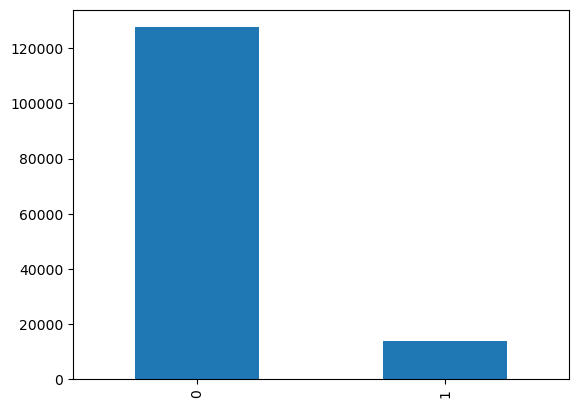

In [11]:
train_answer_df['related'].value_counts().plot(kind = 'bar')

In [12]:
train_answer_df['related'].value_counts()

0    127547
1     14089
Name: related, dtype: int64

### 根据缺失比例过滤

In [13]:
def filter_data(df,cut_value = 0.33):
    length,ans = df.shape[0],[]
    for col in df.columns:
        per_col = df[col].isnull().sum() / length
        if per_col < cut_value:
            ans.append(col)
    return ans

In [14]:
disease_feature1_df_col = filter_data(disease_feature1_df)
disease_feature2_df_col = filter_data(disease_feature2_df)
disease_feature3_df_col = filter_data(disease_feature3_df)

In [15]:
train_food_df_col = filter_data(train_food_df)

### 复制一份数据

In [16]:
df1 = disease_feature1_df[disease_feature1_df_col].copy(deep = True)
df2 = disease_feature2_df[disease_feature2_df_col].copy(deep = True)
df3 = disease_feature3_df[disease_feature3_df_col].copy(deep = True)
tf = train_food_df[train_food_df_col].copy(deep = True)

查看每份数据id个数

In [17]:
print('df1的disease_id总个数：{}'.format(df1['disease_id'].nunique()),'df1数据大小{}'.format(df1.shape))
print('df2的disease_id总个数：{}'.format(df2['disease_id'].nunique()),'df2数据大小{}'.format(df2.shape))
print('df3的disease_id总个数：{}'.format(df3['disease_id'].nunique()),'df3数据大小{}'.format(df3.shape))


df1的disease_id总个数：220 df1数据大小(220, 997)
df2的disease_id总个数：301 df2数据大小(301, 3182)
df3的disease_id总个数：392 df3数据大小(392, 1454)


填充缺失值

In [18]:
def fill_null_val(df):
    for col in df.columns:
        df[col].fillna(df[col].mode(),inplace = True)

In [19]:
for df in [df1,df2,df3,tf]:
    fill_null_val(df)

方差过滤数据

In [20]:
def var_filter(df,setval = 0.5):
    ans = []
    for col in df.columns:
        if str(df[col].dtype) == 'object' or col == 'related_prob':
            ans.append(col)
            continue
        else:
            curval = df[col].var()
            if curval > setval:
                ans.append(col)
    print(df[ans].shape)
    return df[ans]

In [21]:
df1_1 = var_filter(df1,setval = 0.1)
df2_1 = var_filter(df2,setval = 0.1)
df3_1 = var_filter(df3,setval = 0.01)
tf1 = var_filter(tf)

(220, 300)
(301, 1080)
(392, 284)
(348, 39)


In [22]:
def std_filter(df,setval = 3):
    ans = []
    for col in df.columns:
        if str(df[col].dtype) == 'object':
            ans.append(col)
        else:
            curstd = df[col].std()
            if curstd > setval:
                ans.append(col)
    print(df[ans].shape)
    return df[ans]

In [23]:
df1_2 = var_filter(df1_1,setval = 0.11599)
df2_2 = var_filter(df2_1,setval = 0.1093)
df3_2 = var_filter(df3_1,setval = 0.019)
tf2 = std_filter(tf1,setval = 0.1160)

(220, 47)
(301, 27)
(392, 38)
(348, 39)


###### 

In [24]:
def pearson(df,col1,col2):
    covar = df[col1].cov(df[col2])
    var1 = df[col1].var()
    var2 = df[col2].var()
    return covar / math.sqrt(var1 * var2)

In [25]:
def pearson_filter(df,cols,ans,thres = 0.33):
    L = len(cols)
    for i in range(1):
        if i + 1 >= L:
            break
        for j in range(i +1,L):
            out = pearson(df,cols[i],cols[j])
            if out > -1 * thres and out < thres:
                if cols[i] not in ans:
                    ans.append(cols[i])
                    ans.append(cols[j])
                else:
                    ans.append(cols[j])
        print(df[ans].shape)
        print(len(ans))
        return ans

In [26]:
def split_cols(df):
    cate_cols,float_cols = [],[]
    for col in df.columns:
        if str(df[col].dtype) == 'object' or col == 'related_prob':
            cate_cols.append(col)
        else:
            float_cols.append(col)
    return cate_cols,float_cols

In [27]:
tf2_cate,tf2_float = split_cols(tf2)

In [28]:
def get_person_filter_df(tf2,tf2_cate,tf2_float,thres = 0.33):
    ans = []
    ans += tf2_cate
    ans = pearson_filter(tf2,tf2_float,ans,thres)
    return  tf2[ans]

In [29]:
tf3 = get_person_filter_df(tf2,tf2_cate,tf2_float)

(348, 31)
31


In [30]:
df1_cate,df1_float = split_cols(df1_2)
df2_cate,df2_float = split_cols(df2_2)
df3_cate,df3_float = split_cols(df3_2)

In [31]:
df1_3 = get_person_filter_df(df1_2,df1_cate,df1_float,thres = 0.5)
df2_3 = get_person_filter_df(df2_2,df2_cate,df2_float,thres = 0.5)
df3_3 = get_person_filter_df(df3_2,df3_cate,df3_float,thres = 0.5)

(220, 1)
1
(301, 1)
1
(392, 34)
34


In [32]:
def fill_food_null(df):
    for col in df.columns:
        if str(df[col].dtype) == 'object':
            continue 
        df[col].fillna(df[col].mean(),inplace = True)
    return df

In [33]:
tf3 = fill_food_null(tf3)

C:\Users\m1824\AppData\Local\Temp\ipykernel_11224\3465228131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].mean(),inplace = True)


In [34]:
tf3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   food_id  348 non-null    object 
 1   N_6      348 non-null    float64
 2   N_17     348 non-null    float64
 3   N_22     348 non-null    float64
 4   N_42     348 non-null    float64
 5   N_48     348 non-null    float64
 6   N_49     348 non-null    float64
 7   N_50     348 non-null    float64
 8   N_59     348 non-null    float64
 9   N_60     348 non-null    float64
 10  N_61     348 non-null    float64
 11  N_62     348 non-null    float64
 12  N_90     348 non-null    float64
 13  N_94     348 non-null    float64
 14  N_101    348 non-null    float64
 15  N_106    348 non-null    float64
 16  N_113    348 non-null    float64
 17  N_114    348 non-null    float64
 18  N_119    348 non-null    float64
 19  N_142    348 non-null    float64
 20  N_145    348 non-null    float64
 21  N_147    348 non

In [35]:
train_df = pd.merge(train_answer_df,tf3,how = 'left',on = 'food_id')
train_df = pd.merge(train_df,df3_3,how = 'left',on = 'disease_id')

In [36]:
train_df.head()

,food_id,disease_id,related,N_6,N_17,N_22,N_42,N_48,N_49,N_50,...,F_3180,F_3272,F_3519,F_3903,F_3931,F_4105,F_4142,F_4229,F_4316,F_4616
0,food_0,disease_998,0,0.0,2.1,0.0,23.0,0.056,0.409,0.069,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,food_0,disease_861,0,0.0,2.1,0.0,23.0,0.056,0.409,0.069,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,food_0,disease_559,0,0.0,2.1,0.0,23.0,0.056,0.409,0.069,...,0.0,0.0,0.0,0.0,0.0,0.053024,0.0,0.0,0.081333,0.0
3,food_0,disease_841,0,0.0,2.1,0.0,23.0,0.056,0.409,0.069,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,food_0,disease_81,0,0.0,2.1,0.0,23.0,0.056,0.409,0.069,...,0.0,0.0,0.0,0.0,0.0,0.071563,0.0,0.0,0.000000,0.0


In [37]:
def fill_df_null(df):
    for col in df.columns:
        if str(df[col].dtype) == 'object':
            continue
        df[col].fillna(df[col].mean(),inplace = True)
    return df

In [38]:
train_df = fill_df_null(train_df)

In [39]:
def filter_outlier(df):
    cols = [col for col in df.columns if col not in ['related','disease_id','food_id']]
    for col in cols:
        up_val = df[col].quantile(0.75)
        down_val = df[col].quantile(0.25)
        IQR = up_val - down_val
        mean_val = df[col].mean()
        df[col] = df[col].apply(lambda x: x if x > down_val - 1.5*IQR and x <= up_val + 1.5*IQR else mean_val)
    return df

In [40]:
cl_train_df = filter_outlier(train_df)

In [41]:
df_train = cl_train_df.sample(frac = 0.3)
df_test = cl_train_df.sample(frac = 0.2)

In [42]:
set(df_train['food_id'].values).difference(set(df_test['food_id'].values))

set()

查看训练集上数据分布

In [43]:
df_train['related'].value_counts()

0    38203
1     4288
Name: related, dtype: int64

In [44]:
df_train_p = df_train[df_train['related'] == 1].copy(deep = True)
df_train_n = df_train[df_train['related'] == 0].copy(deep = True)

数据增强，维持正负比平衡

In [45]:
def expand_positive_negative(df,expand_num):
    cols_max_min = 0
    res = []
    for _ in range(expand_num):
        ex_df = df.copy(deep = True)
        cate_cols = [col for col in ex_df.columns if col in ['disease_id','food_id','related']]
        float_cols = [col for col in ex_df.columns if col not in ['disease_id','food_id','related']]
        for col in float_cols:
            cols_max_min = ex_df[col].quantile(0.75)  - ex_df[col].quantile(0.25) + random.random() * 0.01
            norm_val_list = np.random.uniform(-1,cols_max_min / 100,ex_df.shape[0])
            colval =np.array(ex_df[col])
            norm_val_array =  np.array(norm_val_list)
            ex_df[col] = colval + norm_val_array
        res.append(ex_df[cate_cols + float_cols])
    return res        

In [46]:
plist = expand_positive_negative(df_train_p,expand_num = 9)

In [47]:
train_p = pd.concat(plist,axis = 0)

In [48]:
con_train_df = pd.concat([train_p,df_train_n],axis = 0)

In [49]:
con_train_df['related'].value_counts()

1    38592
0    38203
Name: related, dtype: int64

归一化c处理数据

In [50]:
def norm_cols(df):
    float_cols = [col for col in df.columns if col not in ['disease_id','food_id','related']]
    for col in float_cols:
        max_val = df[col].max()
        min_val = df[col].min()
        df[col] = df[col].apply(lambda x:(x-min_val) /(max_val - min_val + 0.001))
    return df

In [51]:
norm_train_df = norm_cols(con_train_df)

In [52]:
norm_test_df = norm_cols(df_test)

In [53]:
def split_label_predprob(arrs):
    y_pred_new,y_predprob = [],[]
    for a,b in arrs:
        if a > b:
            y_pred_new.append(0)
            y_predprob.append(b)
        else:
            y_pred_new.append(1)
            y_predprob.append(b)
    return y_pred_new,y_predprob
def count_tp_fp(pred_y,true_y):
    count_tp,count_fp,count_fn = 0,0,0
    for y1,y2 in list(zip(pred_y,true_y)):
        if y1 == 1 and y2 == 1:
            count_tp += 1
        elif y1 == 1 and y2 == 0:
            count_fp  += 1
        elif y1 == 0 and y2 == 1:
            count_fn += 1
    return count_tp,count_fp,count_fn


In [54]:
def get_pre_score(norm_train_df,norm_test_df):
    train_x_columns = [x for x in norm_train_df.columns if x not in ['disease_id','food_id','related']]
    test_x_columns = [x for x in norm_test_df.columns if x not in ['disease_id','food_id','related']]
    X = norm_train_df[train_x_columns].values
    Y = norm_train_df['related'].values
#     X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size = 0.2)
    
    X_test = norm_test_df[test_x_columns].values
    Y_test = norm_test_df['related'].values
    
    
    
    model = XGBClassifier()
    model.fit(X,Y)
    ans = model.predict(X_test)
    print(ans)
    
#     y_pred_new,y_predprob = split_label_predprob(ans)
    
    
    acc = metrics.accuracy_score(Y_test,ans)
    auc = metrics.roc_auc_score(Y_test,ans)
    
    tp_num,fp_num,fn_num = count_tp_fp(ans,Y_test)
    print('tp_num:{0},fp_num:{1},fn_num:{2}'.format(tp_num,fp_num,fn_num))
    presion = tp_num / (tp_num + fp_num)
    recall = tp_num / (tp_num + fn_num)
    F1_score = (2 * presion * recall) / (presion + recall)
    print('presion{}'.format(presion),'recall:{}'.format(recall),'F1_score:{}'.format(F1_score))
    print('(F1_score + auc)/2:',(F1_score + auc) / 2)
    return (F1_score + auc) / 2
    

In [55]:
out = get_pre_score(norm_train_df,norm_test_df)

[1 1 1 ... 1 1 1]
tp_num:2829,fp_num:25498,fn_num:0
presion0.0998693825678681 recall:1.0 F1_score:0.18160225959686738
(F1_score + auc)/2: 0.3408011297984337
